In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from tensorflow.keras.models import load_model

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set paths
DATA_DIR = '/content/drive/MyDrive/Spectrogram_datasets'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 30

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes

# Compute class weights (optional, good for imbalance)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Build Transfer Learning Model
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Callbacks
checkpoint_path = "/content/drive/MyDrive/your_project/best_model.keras"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, save_best_only=True)
]

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

# Fine-tune the base model after freezing
base_model.trainable = True
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    class_weight=class_weights,
    callbacks=callbacks
)

# Load best model
model = load_model(checkpoint_path)

# Evaluate
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 192 images belonging to 3 classes.
Found 48 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.2935 - loss: 1.4676

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 852ms/step - accuracy: 0.2950 - loss: 1.4608 - val_accuracy: 0.2292 - val_loss: 1.2891
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.3928 - loss: 1.2288 - val_accuracy: 0.3125 - val_loss: 1.4394
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 511ms/step - accuracy: 0.5025 - loss: 1.1056 - val_accuracy: 0.2500 - val_loss: 1.5512
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 387ms/step - accuracy: 0.5471 - loss: 1.1154 - val_accuracy: 0.2708 - val_loss: 1.4574
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 379ms/step - accuracy: 0.4439 - loss: 1.2554 - val_accuracy: 0.2917 - val_loss: 1.5545
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 521ms/step - accuracy: 0.4586 - loss: 1.1677 - val_accuracy: 0.2500 - val_loss: 1.4999
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 58s 708ms/step - accuracy: 0.4150 - loss: 1.2884 - val_accuracy: 0.2500 - val_loss: 1.3306
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 493ms/step - accuracy: 0.3516 - loss: 1.2501 - val_accuracy: 0.2708 - va

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3472 - loss: 1.0970
Test Accuracy: 33.33%


Mounted at /content/drive
Found 192 images belonging to 3 classes.
Found 48 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3808 - loss: 19.0641

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 90s 13s/step - accuracy: 0.3874 - loss: 19.8606 - val_accuracy: 0.3333 - val_loss: 4.4059
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3984 - loss: 15.5987 - val_accuracy: 0.3333 - val_loss: 4.8865
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.4799 - loss: 12.9659

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4731 - loss: 13.0296 - val_accuracy: 0.3333 - val_loss: 3.6976
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.4265 - loss: 13.0704

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4303 - loss: 12.6089 - val_accuracy: 0.3333 - val_loss: 2.6118
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3853 - loss: 10.2849 - val_accuracy: 0.3333 - val_loss: 3.1832
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.5466 - loss: 10.8104

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5481 - loss: 10.7193 - val_accuracy: 0.2917 - val_loss: 2.0146
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 751ms/step - accuracy: 0.4595 - loss: 5.5010 - val_accuracy: 0.3333 - val_loss: 2.8204
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 963ms/step - accuracy: 0.4631 - loss: 7.4604 - val_accuracy: 0.1875 - val_loss: 2.1649
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 728ms/step - accuracy: 0.5504 - loss: 4.1334 - val_accuracy: 0.2292 - val_loss: 2.1529
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5389 - loss: 5.5635 - val_accuracy: 0.3125 - val_loss: 2.4037
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 751ms/step - accuracy: 0.5283 - loss: 5.3252 - val_accuracy: 0.3333 - val_loss: 2.4421


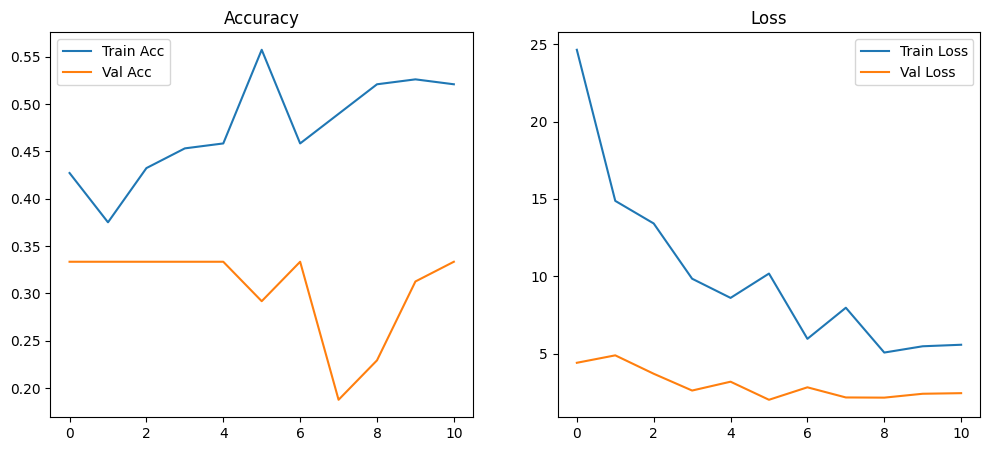

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

          EB       0.53      0.80      0.64        10
          NB       0.53      0.80      0.64        10
          RB       0.00      0.00      0.00        10

    accuracy                           0.53        30
   macro avg       0.36      0.53      0.43        30
weighted avg       0.36      0.53      0.43        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


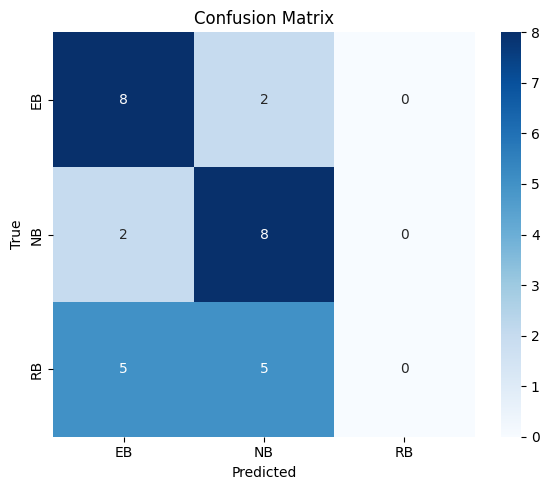

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
BASE_DIR = '/content/drive/MyDrive/Spectrogram_datasets'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 3  # EB, NB, RB

# Data Generator with 80:10 split from training
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.2
)

# Train and validation generators from training folder
train_generator = datagen.flow_from_directory(
    directory=f'{BASE_DIR}/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    directory=f'{BASE_DIR}/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test generator (final 10% in separate folder)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=f'{BASE_DIR}/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# CNN Model
model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(2, 2))

# Block 2
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(2, 2))

# Block 3
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(2, 2))

# Dense layers
model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_breath_cnn_model.h5', save_best_only=True)
]

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Save final model
model.save('final_breath_cnn_model.h5')

# Plot Accuracy/Loss
def plot_history(hist):
    acc, val_acc = hist.history['accuracy'], hist.history['val_accuracy']
    loss, val_loss = hist.history['loss'], hist.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_history(history)

# Evaluation
test_generator.reset()
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()
